# Data Preprocessing

## 1. Import library

In [587]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime



## 2. Data pre-processing

In [620]:
df=pd.read_csv('/Users/yupengshen/DA_portfolio/stock price prediction/NVDA.csv')

In [621]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376237,271468800
1,1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415653,51048000
2,1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383404,34320000
3,1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382210,24436800
4,1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381015,22752000


In [622]:
# Will only predict the close
df=df[['Date','Close']]

In [623]:
df.dtypes

Date      object
Close    float64
dtype: object

In [624]:
# Convert 'Date' from string to datetime 
df['Date']=pd.to_datetime(df['Date'])

In [625]:
df['Date'].max()

Timestamp('2024-04-16 00:00:00')

In [626]:
df.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [627]:
# Set the 'date_column' as the index
df.set_index('Date', drop=True, inplace=True)

In [628]:
df.head()

,Close
Date,
1999-01-22,0.410156
1999-01-25,0.453125
1999-01-26,0.417969
1999-01-27,0.416667
1999-01-28,0.415365


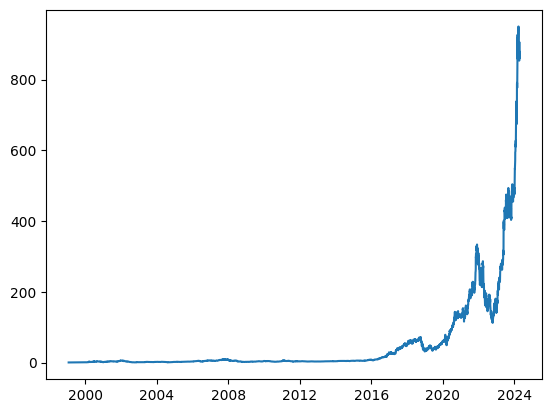

In [629]:
plt.plot(df.index,df['Close'])

In [631]:
# Window
date_input=input("Enter the start date (YYYY-MM-DD): ")
df = df.loc[date_input:]
df

,Close
Date,
2023-04-03,279.649994
2023-04-04,274.529999
2023-04-05,268.809998
2023-04-06,270.369995
2023-04-10,275.790009
...,...
2024-04-10,870.390015
2024-04-11,906.159973
2024-04-12,881.859985


In [632]:
df.index.min()

Timestamp('2023-04-03 00:00:00')

In [633]:
df.index.max()

Timestamp('2024-04-16 00:00:00')

In [634]:
# Convert DataFrame to NumPy array
training_set = df.to_numpy()
training_set

array([[279.649994],
       [274.529999],
       [268.809998],
       [270.369995],
       [275.790009],
       [271.690002],
       [264.950012],
       [264.630005],
       [267.579987],
       [270.019989],
       [276.670013],
       [279.309998],
       [271.040009],
       [271.190002],
       [270.420013],
       [262.410004],
       [269.559998],
       [272.26001 ],
       [277.48999 ],
       [289.100006],
       [282.100006],
       [278.019989],
       [275.619995],
       [286.799988],
       [291.51001 ],
       [285.709991],
       [288.850006],
       [285.779999],
       [283.399994],
       [289.529999],
       [292.130005],
       [301.779999],
       [316.779999],
       [312.640015],
       [311.76001 ],
       [306.880005],
       [305.380005],
       [379.799988],
       [389.459991],
       [401.109985],
       [378.339996],
       [397.700012],
       [393.269989],
       [391.709991],
       [386.540009],
       [374.75    ],
       [385.100006],
       [387.7

In [635]:
# Creating a data structure with 3 past timestamps and 1 output
X = []
y = []

n_future = 1  # Number of days we want to predict into the future
n_past = 3    # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set) - n_future + 1):
    X.append(training_set[i - n_past:i, 0])  # Retrieves past 3 days data
    y.append(training_set[i + n_future - 1, 0])  # Accesses the target day's data

# Convert lists to numpy arrays
X, y = np.array(X), np.array(y)
dates = df.index[n_past:len(training_set) - n_future + 1].to_numpy()

X = X.reshape((len(dates), X.shape[1], 1))

# Print shapes to confirm alignment
print('X shape == {}.'.format(X.shape))
print('y shape == {}.'.format(y.shape))
print('dates shape == {}.'.format(dates.shape))

X shape == (258, 3, 1).
y shape == (258,).
dates shape == (258,).


# Create Models and training

In [636]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

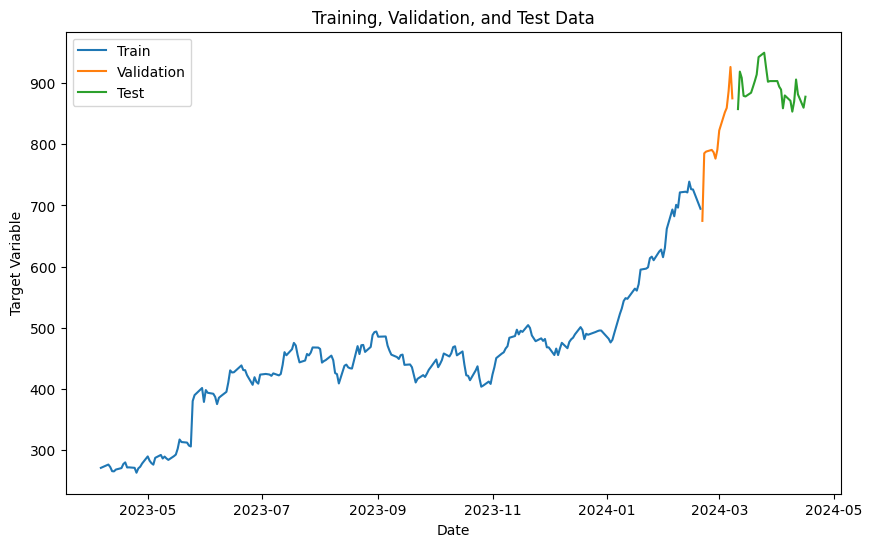

In [637]:
q_80 = int(len(dates) * .85)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the figure

plt.plot(dates_train, y_train, label='Train')
plt.plot(dates_val, y_val, label='Validation')
plt.plot(dates_test, y_test, label='Test')

plt.legend()  # This makes the legend display the labels
plt.title('Training, Validation, and Test Data')
plt.xlabel('Date')
plt.ylabel('Target Variable')

plt.show()


In [638]:
# Adding an additional LSTM layer and a Dropout layer
# Define the model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(16, activation='relu'),
                    layers.Dense(1)])
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# Setup EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor the validation loss
    min_delta=1.55e-10000,    # Minimum change to qualify as an improvement
    patience=25,              # Number of epochs with no improvement after which training will be stopped
    verbose=1,                # Enable verbose output
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity
)

# Setup ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # Monitor the validation loss
    factor=0.5,           # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=25,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1             # Enable verbose output
)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800,callbacks=[early_stopping, reduce_lr])

Epoch 1/800
7/7 [==============================] - 1s 35ms/step - loss: 210834.0156 - mean_absolute_error: 447.8389 - val_loss: 670232.6875 - val_mean_absolute_error: 816.3539 - lr: 0.0010
Epoch 2/800
7/7 [==============================] - 0s 3ms/step - loss: 210498.4062 - mean_absolute_error: 447.4660 - val_loss: 669692.9375 - val_mean_absolute_error: 816.0234 - lr: 0.0010
Epoch 3/800
7/7 [==============================] - 0s 3ms/step - loss: 210188.0938 - mean_absolute_error: 447.1146 - val_loss: 669109.9375 - val_mean_absolute_error: 815.6658 - lr: 0.0010
Epoch 4/800
7/7 [==============================] - 0s 3ms/step - loss: 209812.6719 - mean_absolute_error: 446.6973 - val_loss: 668316.1250 - val_mean_absolute_error: 815.1793 - lr: 0.0010
Epoch 5/800
7/7 [==============================] - 0s 3ms/step - loss: 209311.8906 - mean_absolute_error: 446.1341 - val_loss: 667155.1250 - val_mean_absolute_error: 814.4669 - lr: 0.0010
Epoch 6/800
7/7 [==============================] - 0s 3ms/s

7/7 [==============================] - 0s 896us/step


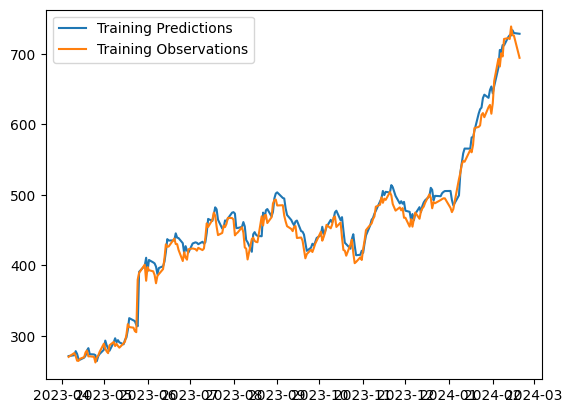

In [639]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 9ms/step


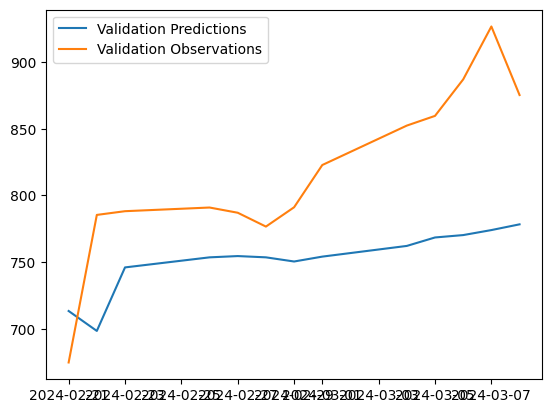

In [640]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 9ms/step


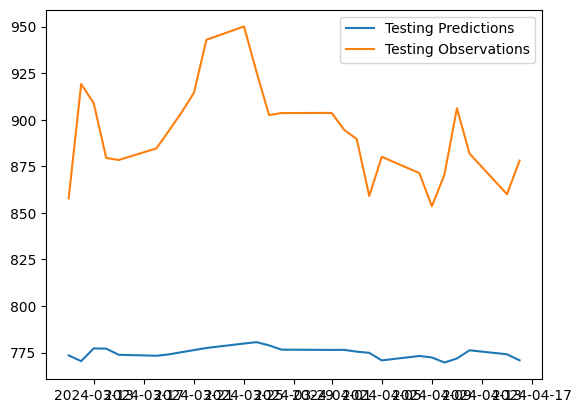

In [641]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

# Recursive Prediction

Recursive prediction begins witht eh final data point in the available dataset, which I assume is the last date in the training set. This method uses this last known data point as the starting basis for generating subsequent predictions. 

In [642]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 8ms/step


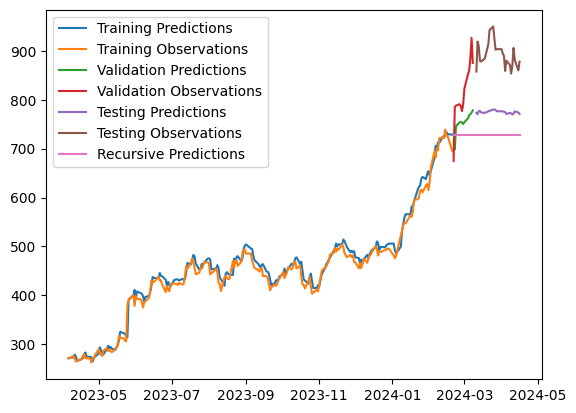

In [643]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

## Predicting the next day

In [653]:
dates[-n_future:]

array(['2024-04-16T00:00:00.000000000'], dtype='datetime64[ns]')

In [654]:
dates[-1]

numpy.datetime64('2024-04-16T00:00:00.000000000')

In [655]:
future_datelist = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=n_future, freq='1d').tolist()

In [656]:
future_datelist

[Timestamp('2024-04-17 00:00:00')]

In [657]:
# Convert Pandas Timestamp to Datetime object
future_date = []
for this_timestamp in future_datelist:
    future_date.append(this_timestamp.date())


In [658]:
predictions_future = model.predict(X[-n_future:])

1/1 [==============================] - 0s 10ms/step


In [659]:
PREDICTION = pd.DataFrame(predictions_future, columns=['Close']).set_index(pd.Series(future_date))


In [660]:
PREDICTION

,Close
2024-04-17,770.845276


From the recursive predictions shown in the above plot. It's clear that the model has no idea on how to predict in the future and it simply think it will be what it was before which is not unreasonable at all. Stock prediction is extremely hard. Although the upward trend in the graph might indicate it's a good stock to buy, there is no absolute certainty in such conclusions. While no model can accurately predict stock on a day-to-day basis, this doesn't make the model useless. Generally, people consider stocks for long-term investments rather than short-term activity. LSTM prediction should be used as part of a broader investment strategy. 